In [1]:
import xgboost as xgb
import pandas as pd
import os
import math
from tqdm import tqdm
from gensim import corpora
from collections import defaultdict
from gensim import models
import sqlite3
import changefinder
import ruptures as rpt

import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import plotly.express as px

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pickle

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
import string
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

from nltk.corpus import stopwords
stop_set = set(stopwords.words('english'))

#set_to_add = {'tamu', 'research', 'university', 'college', 'also', 'student', 'said'}
#stop_set.update(set_to_add)
#lemmatizer = WordNetLemmatizer()
#cleaned = set()
#for word in stop_set:
#    word = ''.join(char for char in word if char not in string.punctuation)
    
    # Lemmatize the word
#    word = lemmatizer.lemmatize(word.lower())  # Lemmatize and convert to lowercase
#    cleaned.add(word)
#stop_set = cleaned
print(stop_set)

{'yours', 'now', 'ma', 'to', 'there', 'where', 'any', 'our', 'does', 'shouldn', "wouldn't", 'him', 'once', "she's", 'who', 'only', 'isn', "shan't", "aren't", 'has', 'this', 'ours', 're', 'into', "you'd", "haven't", 'mustn', 'i', 'in', 'nor', "wasn't", 'she', "you're", 'up', 'under', "you'll", "isn't", 'below', 'from', 'theirs', 'are', 'be', 'most', 'y', 'all', 'will', 'should', 'that', 'against', 'what', 'll', 'both', 'we', 'don', 'shan', 'off', 'at', 'am', 'while', 'then', 'which', 'did', 'wasn', 've', 'not', 'haven', 'some', 'ain', 'the', 'yourself', 'other', 'been', 't', 'aren', 'and', 'before', 'couldn', 'doing', 'but', 's', 'being', 'wouldn', 'as', 'weren', 'was', "mustn't", 'about', 'd', 'herself', 'were', 'own', 'my', 'mightn', 'no', "hadn't", "mightn't", 'such', 'very', "don't", 'down', "couldn't", 'her', 'until', 'further', 'won', 'm', 'doesn', 'during', 'having', 'few', 'had', 'here', 'whom', 'after', 'didn', "it's", 'how', 'it', 'out', 'too', 'why', 'through', 'again', 'is',

In [2]:
def database_connection(read_df):
    database_name = 'T:\\Capstone.db'
    
    conn = sqlite3.connect(database_name, timeout = 5)
    
    #os.chmod("T:\\Testconnection.db", 0o777)
    
    cursor = conn.cursor()    
    
    looping = True
    try:
        while(looping):
            answer = str(input("What would you like to do:\n\nCREATE TOPIC TABLE(CT), CREATE ANALYZED TABLE (CA), LIST OF TABLES(L), FILL ANALYZED DATA (FA), \nFILL TOPIC DATA (FT), READ RAW DATA (RR), READ ANALYZED DATA (RA), OR DELETE TABLE (D): "))
            
            if answer != 'CA' and answer != 'CT' and answer != 'cr' and answer != 'fr' and answer != 'L' and answer != 'l' and answer != 'FA' and answer != 'FT' and answer != 'RA' and answer != 'RR' and answer != 'D' and answer != 'rr' and answer != 'ca' and answer != 'ct' and answer != 'ft' and answer != 'fa' and answer != 'ra' and answer != 'd':
                print('You did not enter a valid action!')
                looping = False
            
            
        ###########LIST TABLE FUNCTION######################  
            elif answer == "L" or answer == "l":
                
                    cursor.execute("select * from SQLite_master")
                    
                    tables = cursor.fetchall()
                    
                    print("Listing all tables from", database_name,"\b:")
                    
                    i = 0
                    for table in tables:
                        print('Table', i, '\b:', table[1])
                        
                        i += 1
                        
                        
                    print("\n")
                    
        ###########CREATE ANALYZED DATA FUNCTION#############################    
            elif answer == "CA" or answer == "ca":
                
                table_name = str(input("What do you want to name the new analyzed data table: \n"))
                with conn:
                    sql = f""" 
                    CREATE TABLE IF NOT EXISTS '{table_name}'
                    (Headline TEXT, Date TEXT, Article TEXT, Publisher TEXT, Website TEXT, neg REAL,
                     neu REAL, pos REAL, compound REAL, sentiment REAL, subjectivity REAL)
                    """
                    cursor.executescript(sql)        
            
    ###########CREATE TOPIC TABLE FUNCTION#############################    
            elif answer == "CR" or answer == "cr":
                
                table_name = str(input("What do you want to name the new rawdata table: \n"))
                with conn:
                    sql = f""" 
                    CREATE TABLE IF NOT EXISTS '{table_name}'
                    (Headline TEXT, Date TEXT, Article TEXT, Publisher TEXT, Website TEXT)
                    """
                    cursor.executescript(sql)            
            
        ###########CREATE TOPIC TABLE FUNCTION#############################    
            elif answer == "CT" or answer == "ct":
                
                table_name = str(input("What do you want to name the new topic table: \n"))
                with conn:
                    sql = f""" 
                    CREATE TABLE IF NOT EXISTS '{table_name}'
                    (Headline TEXT, Date TEXT, Article TEXT, Publisher TEXT, Website TEXT, neg REAL,
                     neu REAL, pos REAL, compound REAL, sentiment REAL, subjectivity REAL,
                     topic_prob REAL)
                    """
                    cursor.executescript(sql)
                    
    ###########FILL ANALYZED DATA FUNCTION#############################        
            elif answer == "FR" or answer == "fr":
                table_name = str(input("What table of raw data do you want to write to: "))
                        
                for i in tqdm (read_df.index):
                    insert_data = (read_df["Headline"].loc[i], read_df["Date"].loc[i], read_df["Article"].loc[i], read_df["Publisher"].loc[i], read_df["Website"].loc[i])
                            
                            
                            
                    with conn:
                        sql = "INSERT INTO {} VALUES (?,?,?,?,?)".format(table_name)
                        cursor.execute(sql, insert_data)            
                
                
        ###########FILL ANALYZED DATA FUNCTION#############################        
            elif answer == "FA" or answer == "fa":
                table_name = str(input("What table of analyzed data do you want to write to: "))
                        
                for i in tqdm (read_df.index):
                    insert_data = (read_df["Headline"].loc[i], read_df["Date"].loc[i], read_df["Article"].loc[i], read_df["Publisher"].loc[i], read_df["Website"].loc[i], read_df["neg"].loc[i], read_df["neu"].loc[i], read_df["pos"].loc[i], read_df['compound'].loc[i], read_df["Sentiment"].loc[i], read_df["Subjectivity"].loc[i])
                            
                            
                            
                    with conn:
                        sql = "INSERT INTO {} VALUES (?,?,?,?,?,?,?,?,?,?,?)".format(table_name)
                        cursor.execute(sql, insert_data)
    
        ###########FILL TOPIC TABLE FUNCTION#############################        
            elif answer == "FT" or answer == "ft":
                table_name = str(input("What topic table do you want to fill with analyzed data: "))
                        
                for i in tqdm (read_df.index):
                    insert_data = (read_df["Headline"].loc[i], read_df["Date"].loc[i], read_df["Article"].loc[i], read_df["Publisher"].loc[i], read_df["Website"].loc[i], read_df["neg"].loc[i], read_df["neu"].loc[i], read_df["pos"].loc[i], read_df['compound'].loc[i], read_df["Sentiment"].loc[i], read_df["Subjectivity"].loc[i], read_df["Topic_Prob"].loc[i])
                            
                            
                            
                    with conn:
                        sql = "INSERT INTO {} VALUES (?,?,?,?,?,?,?,?,?,?,?,?)".format(table_name)
                        cursor.execute(sql, insert_data)
                   
        
                
                #cursor.executemany("INSERT INTO topic0_test VALUES (?,?,?,?,?,?,?,?,?)", datas)
            
            
        #CREATE TABLE RawData(headline TEXT,date TEXT,article TEXT,publisher TEXT,neg REAL,neu REAL,pos REAL,compound REAL,sentiment REAL,subjectivity REAL   )
            
        ###########READ RAW FUNCTION##################################
        
            elif answer == "RR" or answer == 'rr':
                table_name = str(input("What table of raw data do you want to read from: "))
                
                #read_df = pd.DataFrame(columns = ["Headline", "Date", "Article", "Publisher", "Website"])
                index = 0
                for row in cursor.execute("SELECT rowid, * FROM {}".format(table_name)):
                    headline = row[1]
                    date = row[2]
                    article = row[3]
                    publisher = row[4]
                    website = row[5]
                    
                    insert_row = pd.Series([headline, date, article, publisher, website], index = read_df.columns)
                    
                    read_df.loc[index] = insert_row
                    index += 1
                    
                print("The raw data was put into the following pandas Dataframe")
                print(read_df)
        
        
        
        ###########READ ANALYZED FUNCTION#############################
            elif answer == 'RA' or answer == 'ra':
                table_name = str(input("What table of analyzed data do you want to read from: "))
                index = 0
                for row in cursor.execute("SELECT rowid, * FROM {}".format(table_name)):
                        headline = row[1]
                        date = row[2]
                        article = row[3]
                        publisher = row[4]
                        website = row[5]
                        neg = row[6]
                        neu = row[7]
                        pos = row[8]
                        compound = row[9]
                        
                        
                        Sentiment = row[10]
                        Subjectivity = row[11]
                        '''date = old_df["date"].iloc[j[0]]'''
    
                                #print(topic_df.columns)
                        insert_row = pd.Series([headline, date, article, publisher, website, neg, neu, pos, compound, Sentiment, Subjectivity], index = read_df.columns)
                        #print(row)
                        
                        read_df.loc[index] = insert_row
                        index += 1
                        
                print("The analyzed data was put into the following pandas Dataframe")
        
                print(read_df)
                        
                        
                        
                        
                        
        ###########DELETE FUNCTION#############################    
            elif answer == "D" or answer == 'd':
                table_name = str(input("What table do you want to delete: "))
        
                         
                cursor.execute("DROP TABLE {}".format(table_name))
                conn.commit()
                
                
                #Following is code used to delete rows, could be useful if I
                #don't want to delete the whole table and rather specific rows
                '''for row in tqdm(cursor.execute("SELECT rowid, * FROM topic0_test")):    
                         rowids = row[0]    
        
                         sql = f"""
                         DELETE FROM topic0_test
                         WHERE rowid = '{rowids}'
                         """
                    
                         cursor.executescript(sql)
                         conn.commit()'''
                
             
        #Following is just to print out each row to terminal
        '''
        for row in cursor.execute("SELECT rowid, * FROM datatest"):
            print(row)'''

    except Exception as error:
        conn.close()
        print("You threw this error:\n\n", type(error).__name__, "\b:", error)
        print("\n\nYour connection to the database was closed")
    
    else:
        conn.close()
        print("Every thing worked perfectly")    
    
    
    
    

    

In [3]:
def create_texts(article):
    texts = [ [word for word in document.lower().split() if word not in stop_set] for document in article]



    frequency = defaultdict(int)

    for text in texts:
        for token in text:
            frequency[token] += 1

    #texts = [ [token for token in text if frequency[token] > 1] for text in texts]





    return texts

In [4]:
def compute_coherence(dictionary, corpus, texts, cohere_vers, chunksize,
                      limit, start, step, alpha, beta):
## Iterates through all the number of topics defined by start and stop and creating LDA models to calculate the coherence
    coherence_vals = []
    results = {'topic_num' :[],
               'alpha' : [],
               'beta' : [],
               'coherence' : []}
    filename = input(str("What do you want to name the file (Check your files so you don't overwrite stuff stupid):"))
    file = "C:\\Users\\jimni\\LocalCapstone\\" + filename + ".csv"
    pd.DataFrame(results).to_csv(file, index = False)

    pbar = tqdm(total = (len(alpha) * len(beta) * len(range(start,limit,step))))
    for i in range(start,limit,step):
        for j in alpha:
            for k in beta:
                num_topics = i
                lda_model = models.ldamodel.LdaModel(corpus, 
                                                     id2word=dictionary, 
                                                     num_topics=num_topics,
                                                     chunksize = chunksize,
                                                     iterations = iterations,
                                                     passes = passes, 
                                                     eval_every = eval_every,
                                                     eta = k,
                                                     alpha = j,
                                                     random_state = 3)
                coherencemod=models.coherencemodel.CoherenceModel(model=lda_model,
                                                                  texts=texts,
                                                                  dictionary=dictionary,
                                                                  coherence='c_v')
                results['alpha'].append(j)
                results['beta'].append(k)
                results['topic_num'].append(i)
                results['coherence'].append(coherencemod.get_coherence())
                coherence_vals.append(coherencemod.get_coherence())
                #print("Num_topics:",i, "Coherence:",coherencemod.get_coherence())
                pbar.update(1)
    pbar.close()
    pd.DataFrame(results).to_csv(file, index = False)
            

        
    return coherence_vals

In [5]:
def cosine_simil_score(a,b):
## Function to check for duplicates and also outlier documents that are not related to other articles in the corpus
    thing = a.copy()
    thing2 = b.copy()


    ## Loops to create document matrix that are the same size ##
    if len(thing) != len(thing2):
        if len(thing) > len(thing2):
            diff = len(thing)-len(thing2)
            for i in range(0,diff):
                thing2.append((0,0))
        else:
            diff = len(thing2) - len(thing)
            for i in range(0,diff):
                thing.append((0,0))


    ## Creates word vectors to do cosine simularity on ##
    wordsA = []
    wordsB = []
    for i in thing:
        wordsA.append(i[0])
    for i in thing2:
        wordsB.append(i[0])



    ## Math on the word vectors
    dot = np.dot(wordsA,wordsB) 
    magA = np.linalg.norm(wordsA) 
    magB = np.linalg.norm(wordsB) 


    css = np.arccos(dot / (magA *magB)) * (180 / np.pi)
    return css


In [31]:
read_df = pd.DataFrame(columns = ["Headline", "Date", "Article", "Publisher", "Website"])

database_connection(read_df)


What would you like to do:

CREATE TOPIC TABLE(CT), CREATE ANALYZED TABLE (CA), LIST OF TABLES(L), FILL ANALYZED DATA (FA), 
FILL TOPIC DATA (FT), READ RAW DATA (RR), READ ANALYZED DATA (RA), OR DELETE TABLE (D):  rr
What table of raw data do you want to read from:  RawData_3_18


The raw data was put into the following pandas Dataframe
                                               Headline        Date  \
0     tamu investigating large scale cheating case u...  12/16/2020   
1     tamu diversity increase without affirmative ac...  06/19/2016   
2     katherine bank tamu incoming president say pla...  04/09/2021   
3      white nationalist rally tamu university canceled  08/14/2017   
4     tamu official say moving sul ross statue longe...  01/27/2021   
...                                                 ...         ...   
2502  goldsmith makarova advance ita national fall c...  11/04/2021   
2503         tamu take florida advance sec championship  04/20/2024   
2504  tamu track field dominates final home meet hon...  04/21/2024   
2505  layoff upheaval texas university spur fear law...  04/19/2024   
2506  year fatal bonfire tamu considers bringing stu...  04/09/2024   

                                                Article      Publisher  \
0     need stay 

What would you like to do:

CREATE TOPIC TABLE(CT), CREATE ANALYZED TABLE (CA), LIST OF TABLES(L), FILL ANALYZED DATA (FA), 
FILL TOPIC DATA (FT), READ RAW DATA (RR), READ ANALYZED DATA (RA), OR DELETE TABLE (D):  q


You did not enter a valid action!
Every thing worked perfectly


In [32]:
dataframe = read_df.copy()
#print(dataframe)

article = dataframe["Article"].to_list()
texts = create_texts(article)
index = 0
tribune_set = {'sign', 'brief', 'daily', 'newsletter', 'keep','reader', 'speed', 'essential','texas','news'}
#print(texts[2])
#    texts = [ [word for word in document.lower().split() if word not in stop_set] for document in article]
#print(article[1521])

for i in texts:
    if not i:
        texts.pop(index)
        print(index)
    elif i[0] == 'sign' and i[1] == 'brief':
        start_index = 0
        end_index = 12  # Range of indices you want to consider
        
        texts[index] = [word for k, word in enumerate(i) if k < start_index or k >= end_index or word not in tribune_set]
    
        #print(i[0:13])
    index += 1

#print(texts[2][0:20])

combined_texts = [' '.join(sublist) for sublist in texts]
#print(combined_texts[2])
dataframe['Article'] = combined_texts
#print(dataframe)
dataframe = dataframe.dropna()
#print(dataframe)

#results dicitonary is a list for the NLTK scores
results = {}

#blobRes dictionary is a list for blobText scores
blobRes = {}

#texts dictionary is a list for the conent of the articles to be cleaned
texts = {}

#heads is a dictionary for the content of the headings to be cleaned
#heads = {}
sent = SentimentIntensityAnalyzer()
#print("hi")
print("Starting sentiment and subjectivity analysis using NLTK analyzer package")
for row in tqdm(dataframe.index):
    #assign row variables
    text = dataframe["Article"].loc[row]
    Id = row

    
    #normalize text (lowercase)
    text = text.lower()
    
    #for each article, take the polarity scores
    results[Id] = sent.polarity_scores(text)
    texts[Id] = text
    
    #put into a list of cleaned content for each article
    
    #obtain list of each TextBlob sentiment/subjectivity score from the blobtext variable
    blobRes[Id] = (TextBlob(text).sentiment)
#print(results)

    
    #obtain datadrame from results list using pandas
NLTK = pd.DataFrame(results).T
    
    #reset the dataframe index and change column name to Id
NLTK = NLTK.reset_index(drop = True)
    
    #combine the results data witht the original csv dataframe
vaders = pd.concat([dataframe, NLTK], axis = 1, join = 'outer')
    
    #create dataframe using list of TextBlob scores
BlobFrame = pd.DataFrame(blobRes).T
    
    #re-lable columns for better readability
BlobFrame.columns = ['Sentiment', 'Subjectivity']
    
    #reset blobframe index so that when concated, they line up
BlobFrame = BlobFrame.reset_index(drop = True)
    
    #combine the updated csv (from the last line of code) to the textblob scores dataframe
vaderBlob = pd.concat([vaders, BlobFrame], axis = 1, join = 'outer')
    

    
print(vaderBlob)

Starting sentiment and subjectivity analysis using NLTK analyzer package


100%|█████████████████████████████████████████████████████████████████████████████| 2507/2507 [00:10<00:00, 246.34it/s]


                                               Headline        Date  \
0     tamu investigating large scale cheating case u...  12/16/2020   
1     tamu diversity increase without affirmative ac...  06/19/2016   
2     katherine bank tamu incoming president say pla...  04/09/2021   
3      white nationalist rally tamu university canceled  08/14/2017   
4     tamu official say moving sul ross statue longe...  01/27/2021   
...                                                 ...         ...   
2502  goldsmith makarova advance ita national fall c...  11/04/2021   
2503         tamu take florida advance sec championship  04/20/2024   
2504  tamu track field dominates final home meet hon...  04/21/2024   
2505  layoff upheaval texas university spur fear law...  04/19/2024   
2506  year fatal bonfire tamu considers bringing stu...  04/09/2024   

                                                Article      Publisher  \
0     need stay updated coronavirus news texas eveni...  texas tribune   

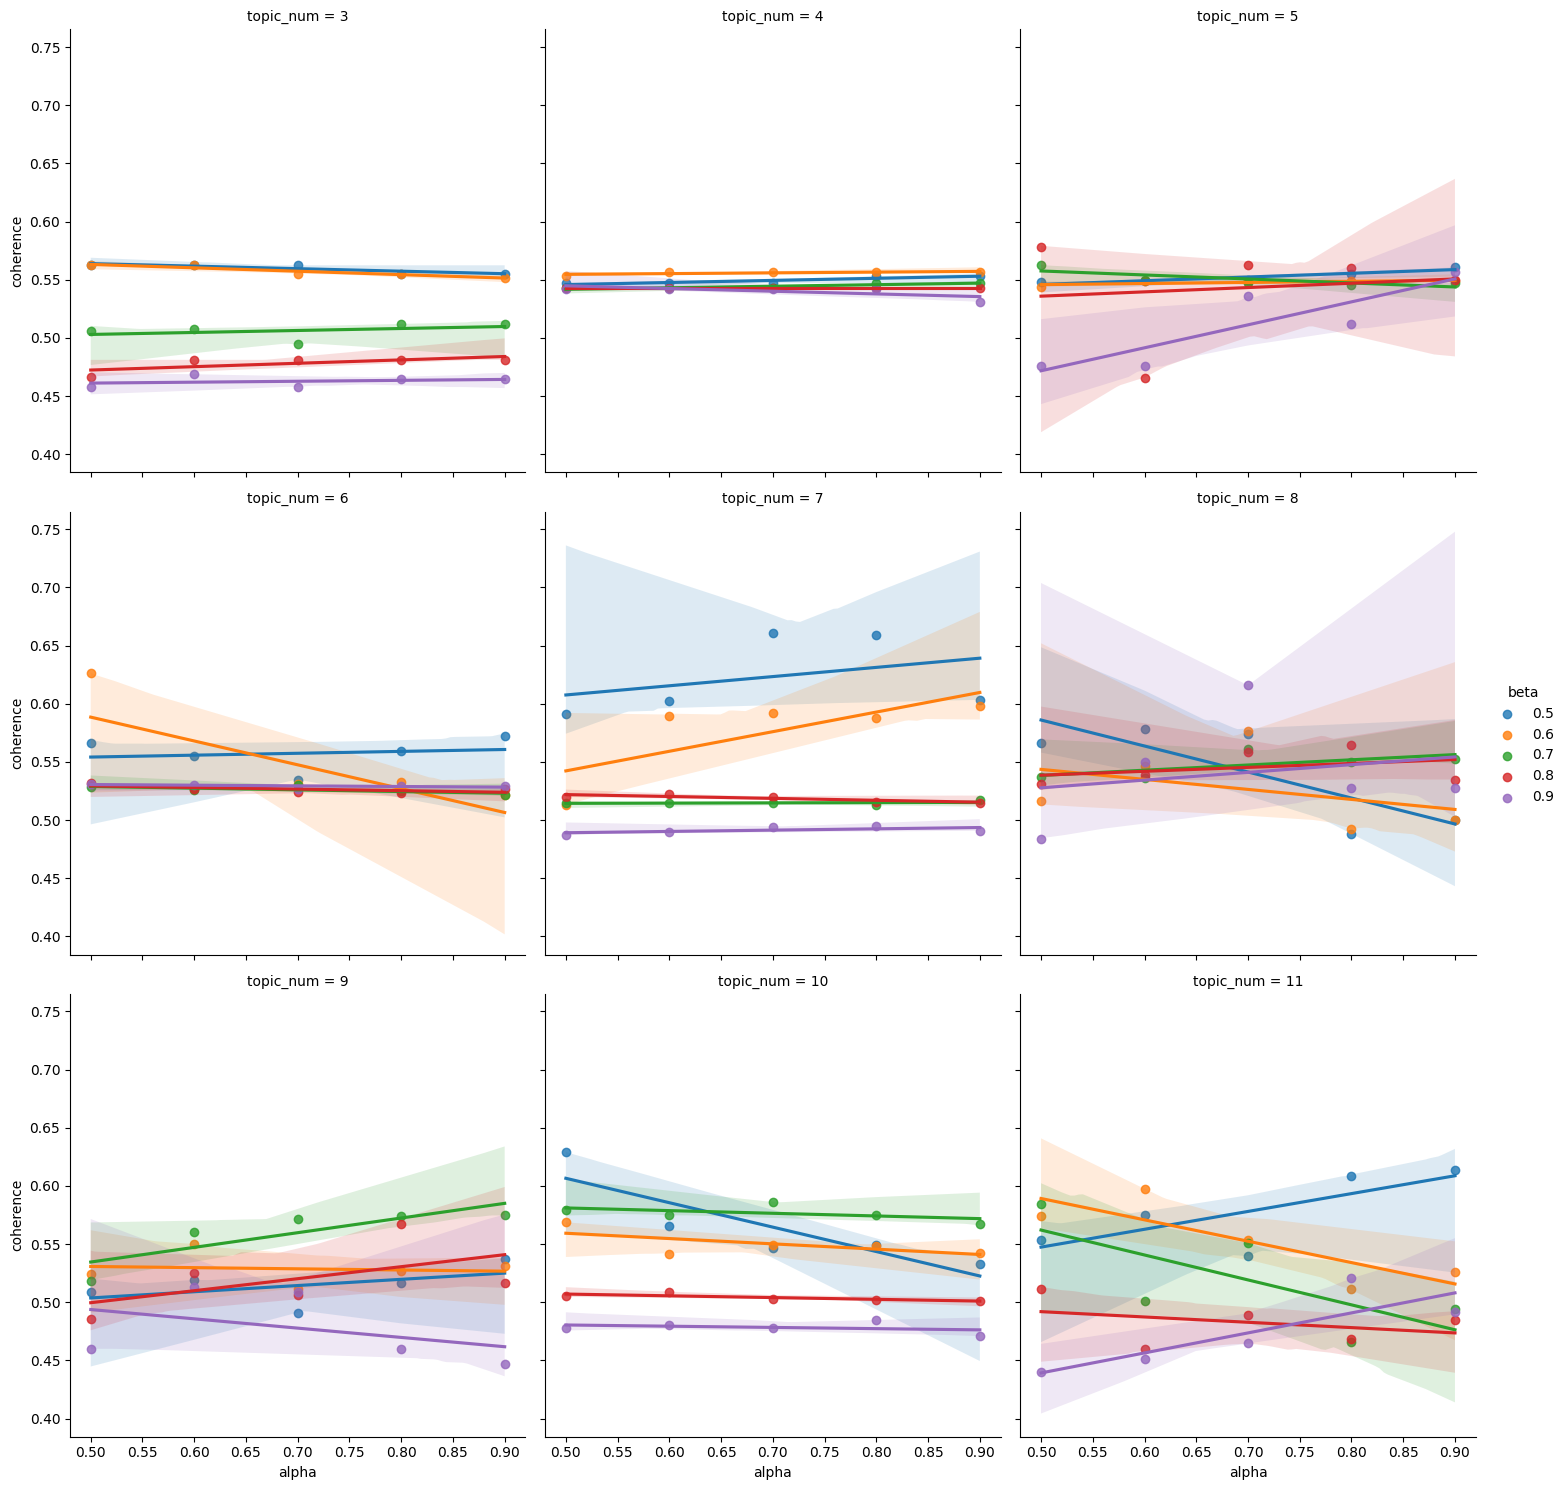

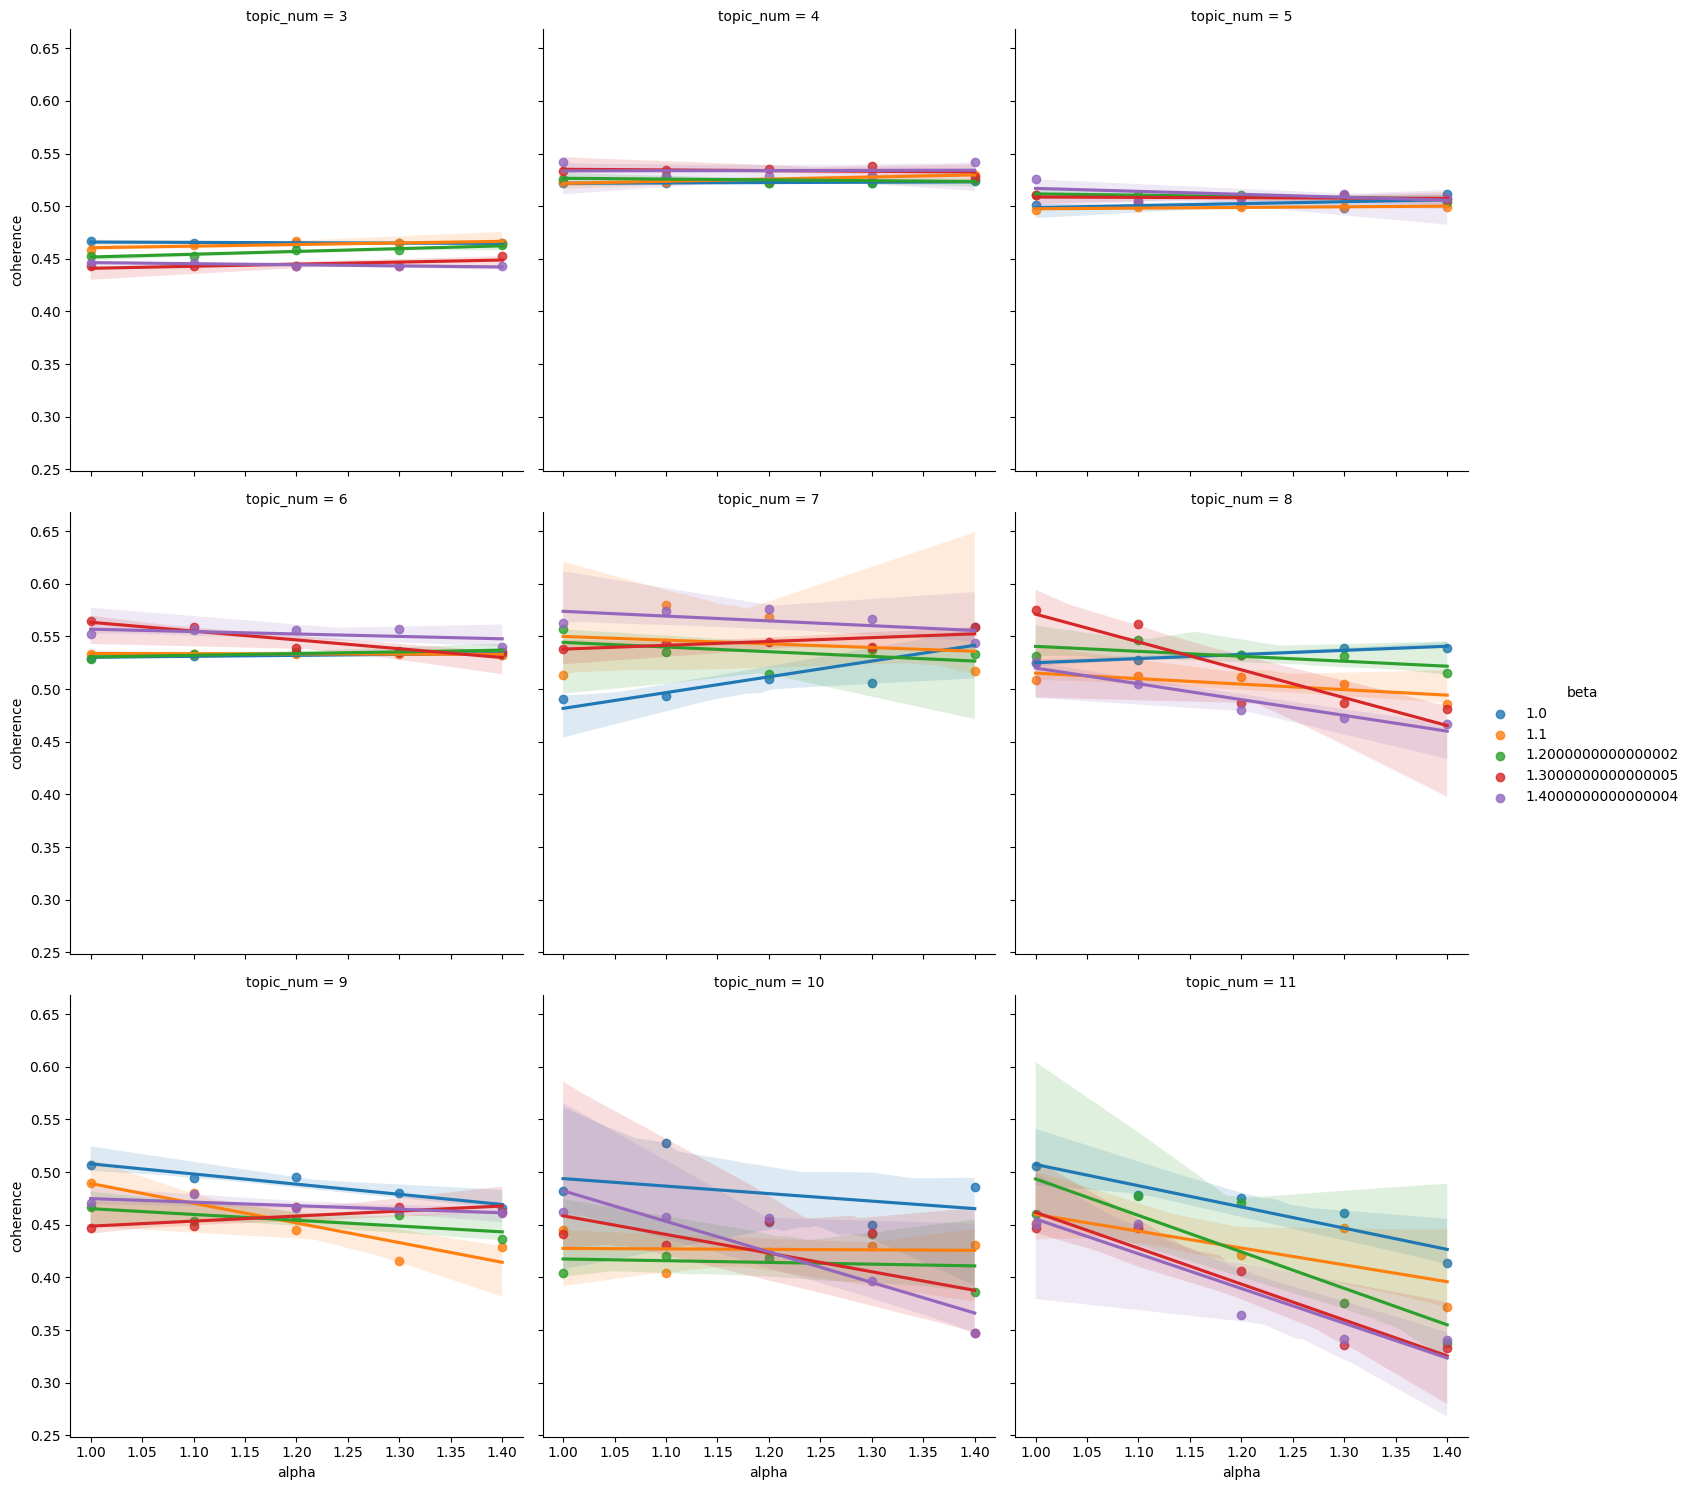

In [3]:
df = pd.read_csv("C:\\Users\\jimni\\LocalCapstone\\tuning3.csv")
#print(df)

sns.lmplot(x="alpha", y="coherence", col = "topic_num", hue="beta", data=df, col_wrap=3)
plt.savefig('.\Tuning3.png')
plt.show()

df = pd.read_csv("C:\\Users\\jimni\\LocalCapstone\\tuning4.csv")
#print(df)

sns.lmplot(x="alpha", y="coherence", col = "topic_num", hue="beta", data=df, col_wrap=3)
plt.savefig('.\Tuning4.png')
plt.show()


In [34]:
#copy the article column to a list so that we can run the topic model algorithms on it
article = vaderBlob['Article'].to_list()
#print(article)


#make a list of lists with the words to be converted into wordIDs
texts = create_texts(article)

#print(len(texts[0]))
#if not texts[452]:
#    print('Hey')
#print(texts[452])

#print(len(texts[0]))

#creating the dictionary and corpus which is what the topic model algorithm uses to find topics
dictionary  = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]



print("\n\nCorpus created... \nNow moving onto coherence evaluation\n")

############################ Creating topic model using best number of topics ############################
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


#NUM_topics = coherence_vals.index(max(coherence_vals)) + start
NUM_topics = 7
chunksize = 100
passes = 15
iterations = 100
eval_every = 10
alpha = 0.7
beta = 0.5


lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                     id2word=dictionary,
                                     num_topics=NUM_topics,
                                     chunksize = chunksize,
                                     iterations = iterations,
                                     passes = passes,
                                     eval_every = eval_every,
                                     random_state = 3,
                                     alpha  = alpha,
                                     eta = beta)
coherence_model_lda = models.coherencemodel.CoherenceModel(model = lda_model,texts = texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)
print("\n\nTopics Found")

### outputs the topics found so we can observe and validate the topic model
for i in lda_model.print_topics(NUM_topics):
    print("Topic", i[0], "\b:\n", i,"\n")



import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_path = os.path.join('.\\ldavis')

if 1 == 1:
    LDAvis_pr = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_path, 'wb') as f:
        pickle.dump(LDAvis_pr, f)

with open(LDAvis_path, 'rb') as f:
    LDAvis_pr = pickle.load(f)

pyLDAvis.save_html(LDAvis_pr, '.\\ldavis.html')

LDAvis_pr



Corpus created... 
Now moving onto coherence evaluation


Coherence Score:  0.545782459306014


Topics Found
Topic 0:
 (0, '0.011*"said" + 0.006*"research" + 0.006*"water" + 0.005*"energy" + 0.004*"department" + 0.004*"science" + 0.004*"temperature" + 0.004*"power" + 0.004*"also" + 0.004*"tamu"') 

Topic 1:
 (1, '0.022*"said" + 0.010*"tamu" + 0.009*"student" + 0.008*"year" + 0.007*"one" + 0.007*"first" + 0.007*"time" + 0.005*"aggie" + 0.005*"like" + 0.005*"really"') 

Topic 2:
 (2, '0.035*"university" + 0.024*"student" + 0.023*"tamu" + 0.013*"campus" + 0.011*"education" + 0.011*"school" + 0.010*"faculty" + 0.008*"program" + 0.008*"college" + 0.007*"dei"') 

Topic 3:
 (3, '0.025*"health" + 0.009*"care" + 0.006*"mental" + 0.006*"disease" + 0.006*"medical" + 0.005*"pet" + 0.005*"said" + 0.005*"dog" + 0.005*"animal" + 0.005*"patient"') 

Topic 4:
 (4, '0.007*"tree" + 0.005*"barbecue" + 0.005*"aguilar" + 0.004*"habib" + 0.004*"forest" + 0.003*"hady" + 0.003*"carlos" + 0.002*"turkey" + 0.0

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.106666 -0.101020       1        1  28.281360
0     -0.095984 -0.008812       2        1  19.775590
5      0.015001 -0.158956       3        1  18.501859
2     -0.055435 -0.150503       4        1  15.073753
6      0.317232  0.137576       5        1  10.808985
3     -0.153887  0.100405       6        1   6.499484
4     -0.133593  0.181310       7        1   1.058968, topic_info=             Term         Freq        Total Category  logprob  loglift
482    university  5519.000000  5519.000000  Default  30.0000  30.0000
455          tamu  8889.000000  8889.000000  Default  29.0000  29.0000
438       student  5444.000000  5444.000000  Default  28.0000  28.0000
461         texas  5502.000000  5502.000000  Default  27.0000  27.0000
2671       health  1681.000000  1681.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
8188       specie    13.638213    90.687146   Topic7  -6.5381   2.6533
1172          pre    14.782611   130.834709   Topic7  -6.4575   2.3674
6645     wildlife    10.406097    63.823771   Topic7  -6.8085   2.7341
1969     american    11.245028   536.686561   Topic7  -6.7310   0.6824
10764    planting     9.311090    27.545769   Topic7  -6.9197   3.4632

[451 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
920        1  0.001317  abbott
920        2  0.001317  abbott
920        3  0.994583  abbott
920        4  0.001317  abbott
920        6  0.001317  abbott
...      ...       ...     ...
13615      2  0.059030     zhu
13615      4  0.059030     zhu
13615      5  0.059030     zhu
13615      6  0.059030     zhu
13615      7  0.708360     zhu

[1998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 3, 7, 4, 5])

In [36]:
####################### Sorting the documents into buckets associated with their respective topic ####################

topic_buckets = [[]]
for j in range(1,NUM_topics):
    topic_buckets.append([])
    
#print(topic_buckets)

## this loops through all the documents and uses the model to see what topic it fits into
## I'll have to tune the probabilities when it comes to the actual data-
## set and find what values work best with the articles we accumulate
for i in range(0,len(corpus)):
    document_topic = list(models.ldamodel.LdaModel.get_document_topics(lda_model, 
                                                                       bow=corpus[i], 
                                                                       minimum_probability=0.15, ## Work with this to determine what value I want to use
                                                                       minimum_phi_value = None,
                                                                       per_word_topics=False))
    
    #if (i == 1):
        #print(corpus[i])
        #print(document_topic)
    for topic in document_topic:
        list_topic = list(topic)
        list_topic.insert(0,i)
        #print(list_topic)
        topic_buckets[list_topic[1]].append(list_topic)
    #print(document_topic)
    
for i in topic_buckets:
    if i:
        print(len(i), "documents in topic", topic_buckets.index(i))
    else:
        print("Topic", topic_buckets.index(i), "doesn't have any articles") 
print()

847 documents in topic 0
1549 documents in topic 1
844 documents in topic 2
323 documents in topic 3
69 documents in topic 4
615 documents in topic 5
472 documents in topic 6



There are 960 datapoints in this tuning set.


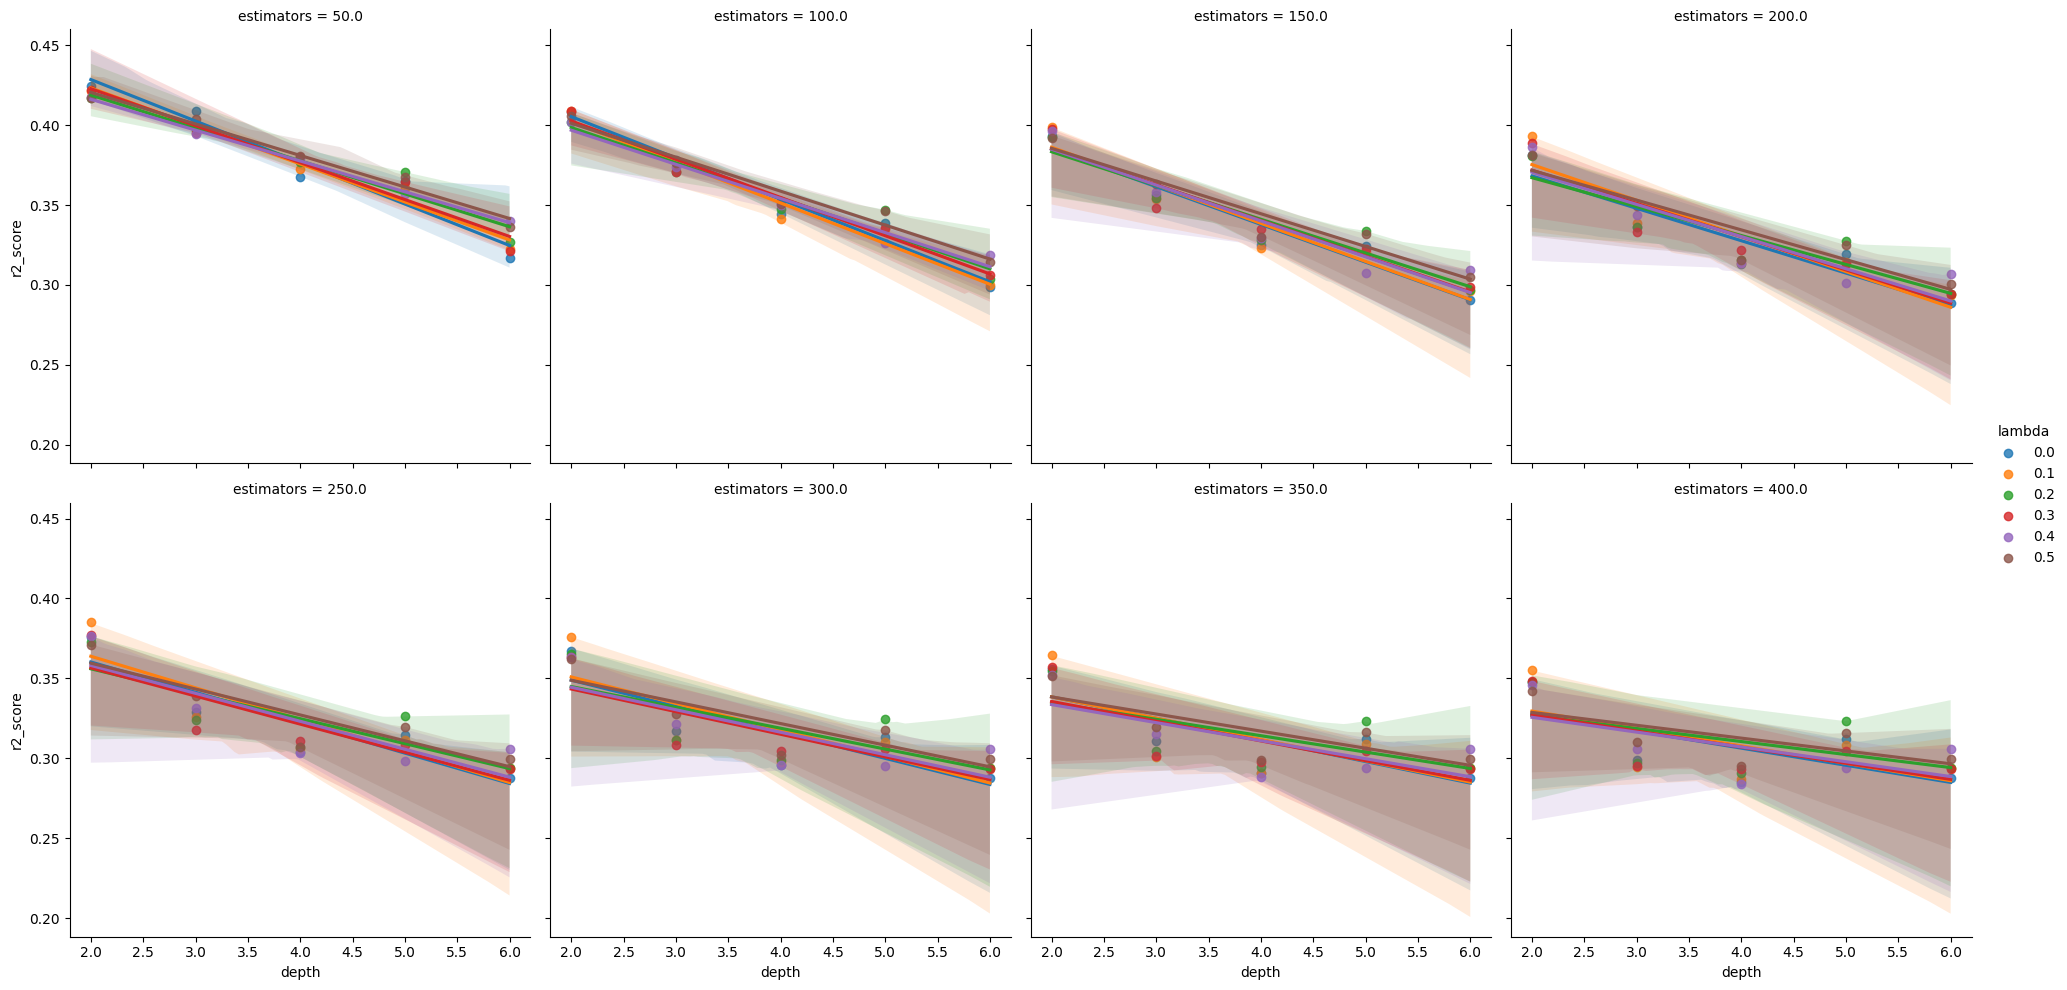

In [5]:
tuning = pd.read_csv("topic1_tuning1.csv")

thing2 = pd.DataFrame(columns=["learning", "depth", "child","lambda", "estimators","r2_score"])
count = 0

for index, row in tuning.iterrows():
    #print(row)
    if row["learning"] == 0.1 and row["child"] == 0.1:
        thing2.loc[len(thing2)] = row


print("There are", len(tuning), "datapoints in this tuning set.")
#print(df2)
sns.lmplot(x="depth", y="r2_score", col = "estimators", hue="lambda", data=thing2, col_wrap=4)
plt.savefig('.\RegressionTuning.png')
plt.show()

Which topic do you want to look at:  5


2023-12-13 00:00:00
Looking at Topic 5


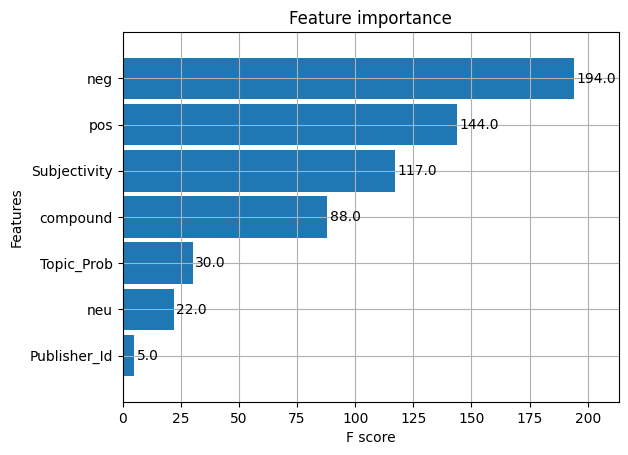

TESTING SCORES FOR ALL ARTICLES IN TOPIC


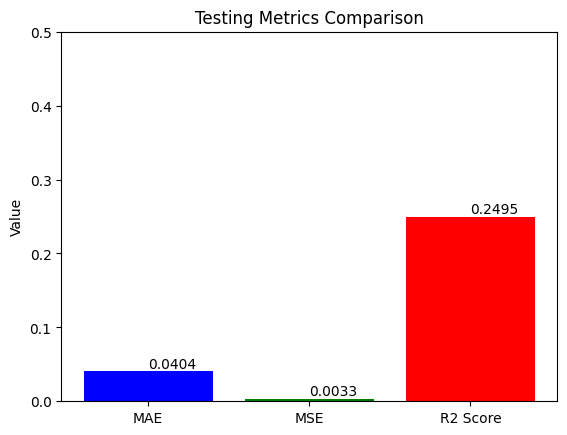

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION


VALIDATION SCORES FOR ALL ARTICLES IN TOPIC


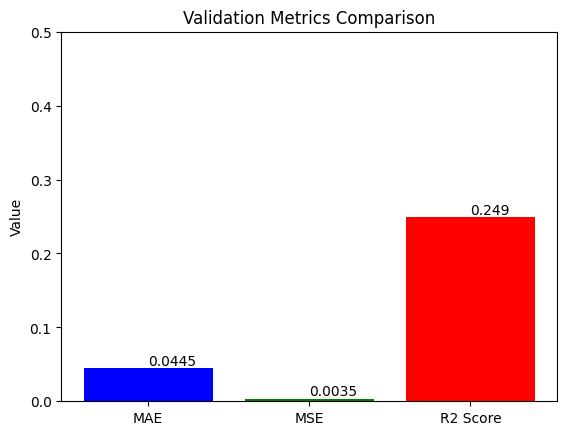

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION


In [10]:

########################################## DATA PREPARATION #############################################################
inp = str(input("Which topic do you want to look at: "))
file_name = ""

if inp == '0':
    
    file_name = "C:\\Users\\jimni\\LocalCapstone\\topic2_csv\\topic0.csv"

elif  inp == '1':
    
    file_name = "C:\\Users\\jimni\\LocalCapstone\\topic2_csv\\topic1.csv"
elif  inp == '2':
    
    file_name = "C:\\Users\\jimni\\LocalCapstone\\topic2_csv\\topic2.csv"

elif  inp == '4':
    
    file_name = "C:\\Users\\jimni\\LocalCapstone\\topic2_csv\\topic4.csv"
elif  inp == '5':
    file_name = "C:\\Users\\jimni\\LocalCapstone\\topic2_csv\\topic5.csv"

df = pd.read_csv(file_name, header = 0)

#print(df)
df = df.drop(labels = ['Unnamed: 0'], axis = 1)

plt.show()

#print(df)

df2 = pd.DataFrame(columns=["year", "month", "day", "Date"])
df3 = df["Date"].copy()
year = []
day = []
month = []

for i in df3:
    if "/" in i:
        #print(i)
        date_object = datetime.strptime(i, "%m/%d/%Y")
        #print(date_object, type(date_object.month))
        year.append(date_object.year)
        day.append(date_object.day)
        month.append(date_object.month)
    else:
        raise Exception("Date is fucked up")


#print(type(year))
df2["year"] = year
df2["day"] = day
df2["month"] = month

test = pd.DataFrame(columns=["year", "month", "day", "Headline", "Date", "Article", "Publisher","Website", "Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic_Prob"])
test[["year", "month", "day"]] = df2[['year','month','day']]
test["Date"] = pd.to_datetime(df2[["year", "month", "day"]])
#test["Date"] = df["Date"].copy()
test[["Headline", "Article", "Publisher","Website", "Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic_Prob"]] = df[["Headline", "Article", "Publisher","Website", "Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic_Prob"]]

#print(type(test))
#print(test)
#print(test[["neg"]].dtypes)
test['Sentiment'] = test['Sentiment'].astype(float)
test['Subjectivity'] = test['Subjectivity'].astype(float)
test['Topic_Prob'] = test['Topic_Prob'].astype(float)
test.sort_values(by=['Date'], inplace = True)

test = test.reset_index()

#test['Sentiment'].plot()

#indecies = []
index = 0
for i in test["Sentiment"]:
    if i == 0:
        test = test.drop(labels = index, axis = 0)
    #print(index)
    index += 1


#print(test)

publist = []
publisher_map = {}
current_id = 0
index = 0
for entry in test["Publisher"]:
    if entry not in publisher_map:
        publisher_map.update({entry:current_id})
        current_id += 1
        
    publist.append(publisher_map.get(entry))
    
test.insert(loc=8, column="Publisher_Id", value = publist)
#print(test)
test["Publisher_Id"] = test["Publisher_Id"].astype(str).astype(int)

########################################### Training/Test/Validation Split #############################################

split = 0.85


dates_to_check = test["Date"].unique()
split_index = int(dates_to_check.shape[0] * split)

split_date = dates_to_check[split_index]
print(split_date)

training = test.query("Date <= @split_date")
valid = test.query("Date > @split_date")

#print(test)

features = ["year", "month", "day", "neg", "neu", "pos", "compound", "Subjectivity", "Topic_Prob", "Publisher_Id"]
#features = ["year", "month", "day", "neg", "neu", "pos", "compound", "Topic_Prob","Publisher_Id"]
#features = ["year", "month", "day", "neg", "neu", "pos","compound", "Subjectivity", "Publisher_Id"]
#features = ["year", "month", "day", "neg", "neu", "pos","compound"]
#features = ["year", "month", "day"]
#features = ["year", "month", "day", "Subjectivity", "Topic_Prob", "Publisher_Id"]

#features = ["year", "month", "day", "topic prob", "subjectivity", "publisher"]
y = ["Sentiment"]
x_train = training[features]
y_train = training[y]
x_valid = valid[features]
y_valid = valid[y]
#print(x_train)
#print(x_valid)



#print(test.isnull().sum())

#train_dmatrix = xgb.DMatrix(data = x_train.values, label = y_train.values)
from sklearn.model_selection import train_test_split

X_train,X_eval,Y_train,Y_eval = train_test_split(x_train, y_train, test_size = 0.15, random_state = 0)
########################## Defining the model based off hyperparameters found in tuning ########################
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)




if inp == '0':
    
    model = xgb.XGBRegressor(n_estimators = 350,
                             max_depth = 2,
                             min_child_weight = 0.01,
                             learning_rate = 0.01,
                             reg_lambda = 0.0)

elif  inp == '1':
    
    model = xgb.XGBRegressor(n_estimators = 300,
                             max_depth = 2,
                             min_child_weight = 0.01,
                             learning_rate = 0.01,
                             reg_lambda = 0.0)
elif  inp == '2':
    
    model = xgb.XGBRegressor(n_estimators = 50,
                             max_depth = 2,
                             min_child_weight = 0.1,
                             learning_rate = 0.1,
                             reg_lambda = 0.5)

elif  inp == '4':
    
    model = xgb.XGBRegressor(n_estimators = 200,
                             max_depth = 3,
                             min_child_weight = 0.01,
                             learning_rate = 0.01,
                             reg_lambda = 0.4)
elif  inp == '5':
    
    model = xgb.XGBRegressor(n_estimators = 200,
                             max_depth = 2,
                             min_child_weight = 0.01,
                             learning_rate = 0.01,
                             reg_lambda = 0.7)


new_inp = "Looking at Topic " + inp
print(new_inp)
#loaded = pickle.load(open("/home/jnieberding/LocalCapstone/env/xgb_model.pkl", 'rb'))
model.fit(X_train, Y_train,
         eval_set = [(X_eval, Y_eval)],  verbose = 0)    

xgb.plot_importance(model, height = 0.9)
plt.show()



fig, ax = plt.subplots(figsize=(200, 200))
xgb.plot_tree(model, num_trees=2, ax=ax)
plt.savefig('.\Topic1_fig.png')
plt.show()

####################################### Prediction Creation ############################################

pred_eval = X_eval.copy() 
pred_valid = x_valid.copy()

#print(pred)
date_stuff = ["year", "month", "day"]

pred_eval["Sentiment prediction"] = model.predict(X_eval)

pred_eval["Date"] = pd.to_datetime(pred_eval[date_stuff])
pred_eval = pred_eval.sort_values(by="Date")
pred_eval["Sentiment"] = Y_eval
#print(pred_eval)
article_list = []
for i in pred_eval.index:
  article_list.append(df['Article'].loc[i])

pred_eval['Article'] = article_list
#print(pred_eval)

pred_valid["Sentiment prediction"] = model.predict(x_valid)
pred_valid["Sentiment"] = y_valid


pred_valid["Date"] = pd.to_datetime(pred_valid[date_stuff])
pred_valid = pred_valid.sort_values(by="Date")

article_list = []
for i in pred_valid.index:
  article_list.append(df['Article'].loc[i])

pred_valid['Article'] = article_list
#print(pred_eval)
#print(pred_valid)

#################################### Evaluation Metrics of the Predicted Values ###########################
from sklearn.metrics import root_mean_squared_error

print("TESTING SCORES FOR ALL ARTICLES IN TOPIC")
mae = mean_absolute_error(pred_eval["Sentiment"], pred_eval['Sentiment prediction'])
#print('Mean Absolute Error:', mae)

mse = mean_squared_error(pred_eval["Sentiment"], pred_eval['Sentiment prediction'])
#print('Mean Squared Error:', mse)


r2 = r2_score(pred_eval["Sentiment"], pred_eval["Sentiment prediction"])
#print('R2 Score:', r2)

# Plotting
fig, ax = plt.subplots()

# Data for plotting
metrics = ['MAE', 'MSE', 'R2 Score']
values = [mae, mse, r2]

# Plot histogram
bars = ax.bar(metrics, values, color=['blue', 'green', 'red'])

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')

# Add title and labels
ax.set_title('Testing Metrics Comparison')
ax.set_ylabel('Value')
# Set y-axis limit from 0 to 1
ax.set_ylim(0, 0.5)
# Show plot
plt.show()

print("MAE: MEAN ABSOLUTE ERROR\nMSE: MEAN SQUARED ERROR\nR2 SCORE: COEFFICIENT OF DETERMINATION")
#adjusted_r2 = 1 - (((1-r2)*(pred_eval.shape[0] - 1)) / (pred_eval.shape[0] - X_eval.shape[1] - 1))
#print('Adjusted R2 Score:',adjusted_r2)


print("\n\nVALIDATION SCORES FOR ALL ARTICLES IN TOPIC")
mae = mean_absolute_error(pred_valid["Sentiment"], pred_valid['Sentiment prediction'])
#print('Mean Absolute Error:', mae)

mse = mean_squared_error(pred_valid["Sentiment"], pred_valid['Sentiment prediction'])
#print('Mean Squared Error:', mse)


r2 = r2_score(pred_valid["Sentiment"], pred_valid["Sentiment prediction"])
#print('R2 Score:', r2)

# Plotting
fig, ax = plt.subplots()

# Data for plotting
metrics = ['MAE', 'MSE', 'R2 Score']
values = [mae, mse, r2]

# Plot histogram
bars = ax.bar(metrics, values, color=['blue', 'green', 'red'])

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')

# Add title and labels
ax.set_title('Validation Metrics Comparison')
ax.set_ylabel('Value')
ax.set_ylim(0, 0.5)
# Show plot
plt.show()
print("MAE: MEAN ABSOLUTE ERROR\nMSE: MEAN SQUARED ERROR\nR2 SCORE: COEFFICIENT OF DETERMINATION")

Feature Vector with all Features

Sentiment Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



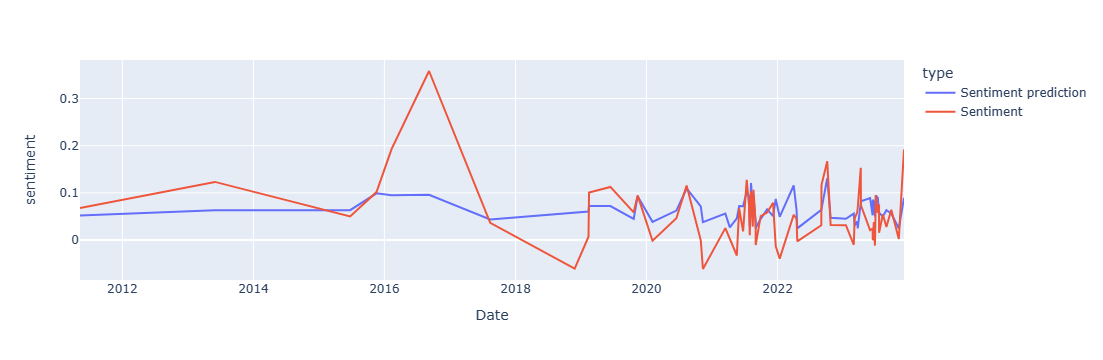

Feature Vector with all Features

Prediction of the Validation Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



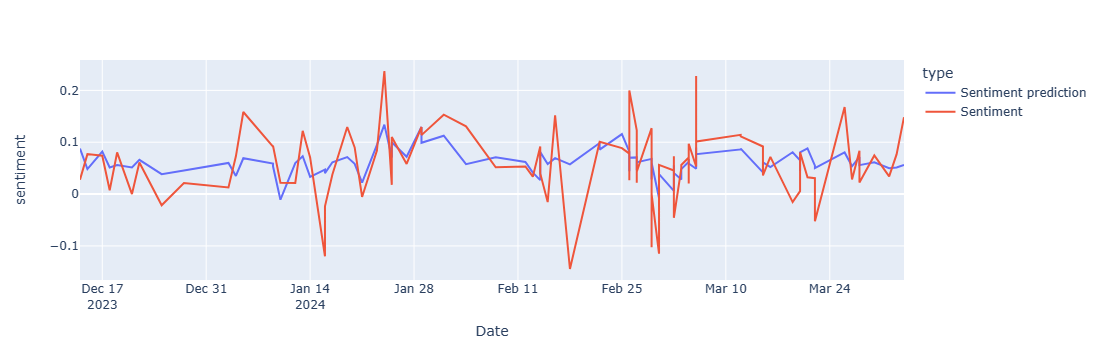

In [11]:
############################## Plotting the results of the Testing Set using during training #############################

print("Feature Vector with all Features\n\nSentiment Prediction of the Testing Set")
pred_vis = pred_eval.melt(id_vars = ["Date"], value_vars = ["Sentiment prediction", "Sentiment"],var_name = "type", value_name = "sentiment")

fig = px.line(pred_vis, x = "Date", y = "sentiment", color = "type", )
fig.show()

################################### Plotting the prediction results of the validation set #################################
    
print("Feature Vector with all Features\n\nPrediction of the Validation Set")
pred_vis = pred_valid.melt(id_vars = [("Date")], value_vars = [("Sentiment prediction"), ("Sentiment")],var_name = "type", value_name = "sentiment")

fig = px.line(pred_vis, x = "Date", y = "sentiment", color = "type", )
fig.show()    

In [40]:
#################################### Gathering the articles that are associated with peaks and valleys ##################

testing = pred_eval.copy()
#print(testing)
##print(testing)
testing = testing.reset_index()



ind = testing['Sentiment'].idxmax(axis = 0)


print("The max predicted sentiment in the testing set was on", testing['Date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['Date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['Article'].loc[i][0:500])
    



ind = testing['Sentiment'].idxmin(axis = 0)


print("\n#######################################\n#######################################\n#######################################\n#######################################\n\nThe min predicted sentiment in the testing set was on", testing['Date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['Date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['Article'].loc[i][0:500])
 

The max predicted sentiment in the testing set was on 2020-08-26 00:00:00


Date: 2020-06-24 00:00:00
The actual sentiment was 0.0905444555444555
The predicted sentiment is 0.15012205
Article:
 tamu agrilife unveiled plan may multi million dollar automated precision phenotyping greenhouse utilize advanced sensor technology enhance agricultural crop area crop health yield nutrition temperature drought stress environmental condition population growth coupled consumer demand nutritious food call new advancement agriculture food system new technology keep said dr patrick stover vice chancellor agriculture life science tamu agrilife director tamu agrilife research tamu agrilife focus import


Date: 2020-08-26 00:00:00
The actual sentiment was 0.5125
The predicted sentiment is 0.189393
Article:
 summer mark anniversary passage signing national literacy act recognition milestone beginning friday george bush presidential library museum accepting donation new gently used book donor receive muse

In [41]:
#################################### Gathering the articles that are associated with peaks and valleys ##################

testing = pred_valid.copy()
#print(testing)
##print(testing)
testing = testing.reset_index()



ind = testing['Sentiment'].idxmax(axis = 0)


print("The max predicted sentiment in the validation set was on", testing['Date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['Date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['Article'].loc[i][0:500])
    



ind = testing['Sentiment'].idxmin(axis = 0)


print("\n#######################################\n#######################################\n#######################################\n#######################################\n\nThe min predicted sentiment in the validation set was on", testing['Date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['Date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['Article'].loc[i][0:500])
 

The max predicted sentiment in the validation set was on 2023-10-27 00:00:00


Date: 2023-10-27 00:00:00
The actual sentiment was 0.1533608058608058
The predicted sentiment is 0.14702298
Article:
 united state supreme court friday denied west tamu university attempt prevent president walter wendler canceling another campus drag show scheduled next week last year wendler banned student led drag show campus saying performance degrade woman student sued president response arguing wendler violated first amendment right texas federal district court denied request relief ban arguing drag show earlier month west tamu student filed emergency application supreme court seeking injunction wendler en


Date: 2023-10-27 00:00:00
The actual sentiment was 0.4155555555555555
The predicted sentiment is 0.22142945
Article:
 college station texas kbtx familiar tamu campus might aware particle accelerator let name scare fascinating piece nuclear technology teaching researcher half century fred abegglen ta

######## Publisher: tamu today ###########

125 Articles in Topic 1 for publisher tamu today in testing set.
TESTING SCORES FOR PUBLISHER: tamu today


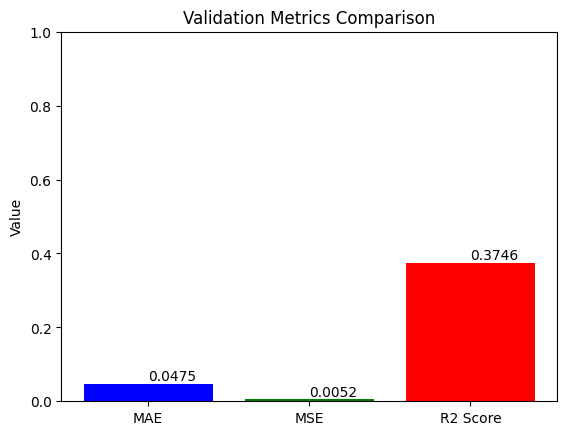

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



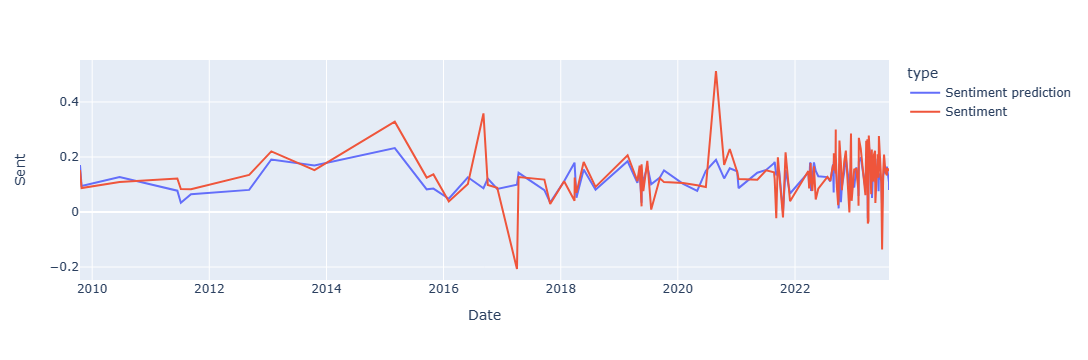

196 Articles in Topic 1 for publisher tamu today in validation set.


VALIDATION SCORES FOR PUBLISHER: tamu today


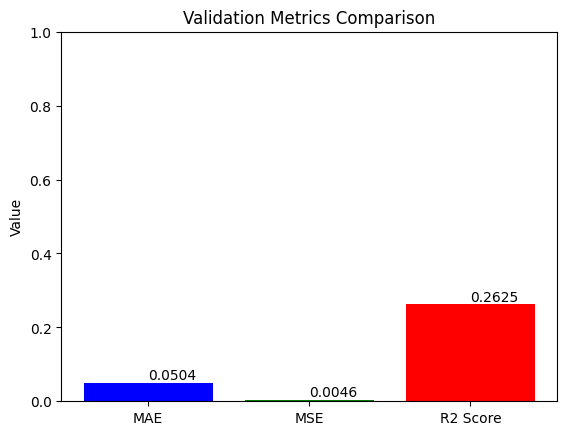

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Validation Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



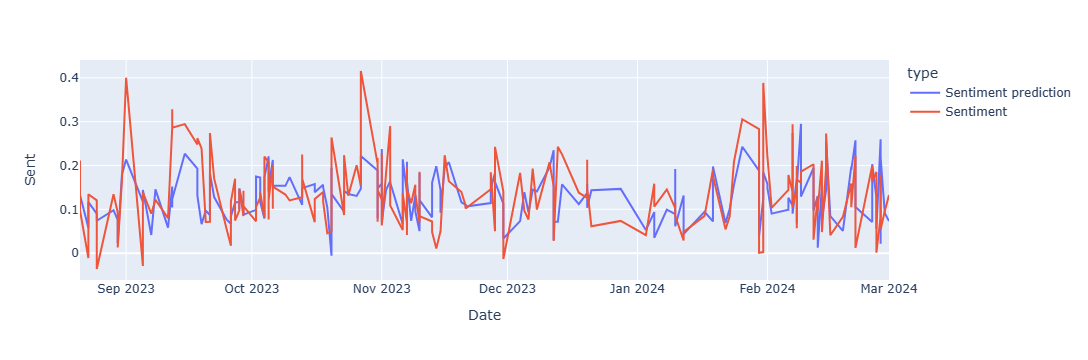

######## Publisher: texas tribune ###########

11 Articles in Topic 1 for publisher texas tribune in testing set.
TESTING SCORES FOR PUBLISHER: texas tribune


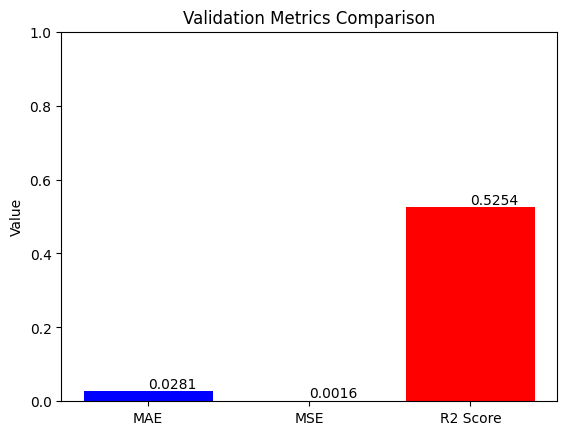

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



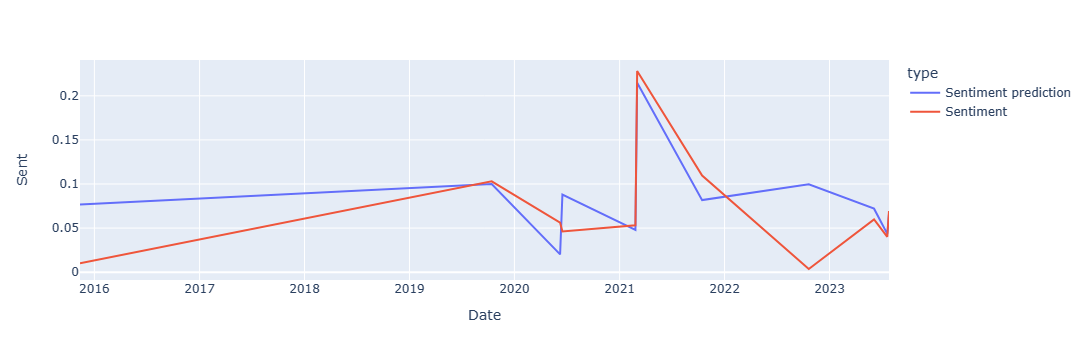

25 Articles in Topic 1 for publisher texas tribune in validation set.


VALIDATION SCORES FOR PUBLISHER: texas tribune


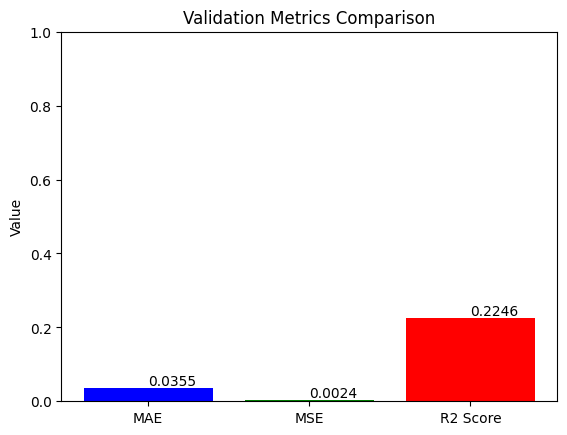

C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Validation Set


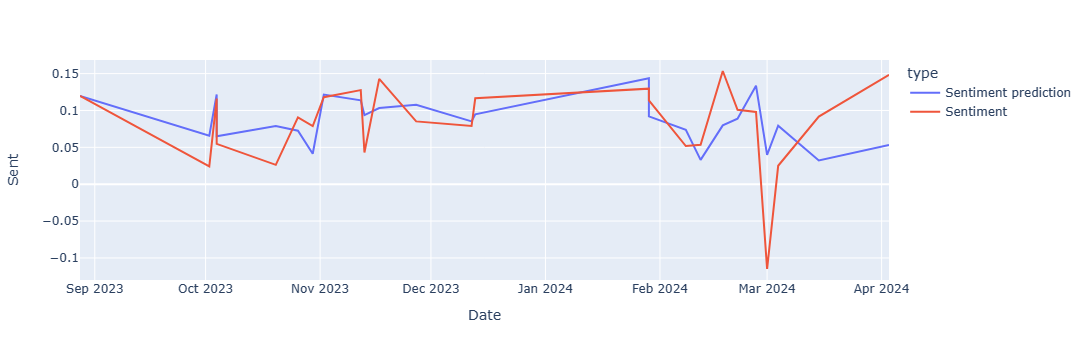

######## Publisher: battalion ###########

18 Articles in Topic 1 for publisher battalion in testing set.
TESTING SCORES FOR PUBLISHER: battalion


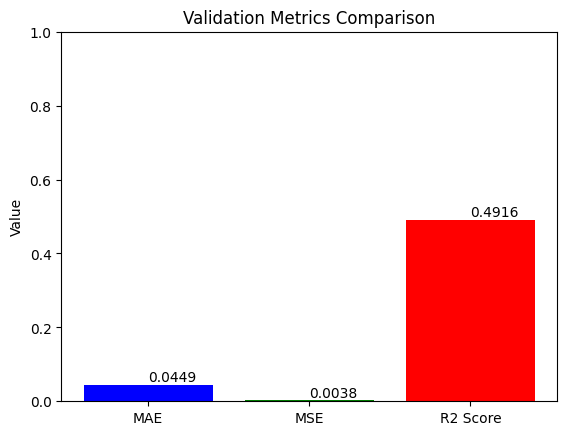

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



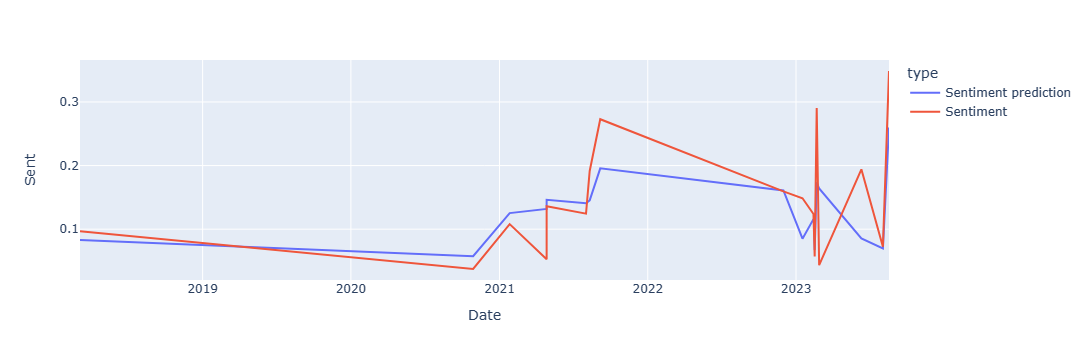

30 Articles in Topic 1 for publisher battalion in validation set.


VALIDATION SCORES FOR PUBLISHER: battalion


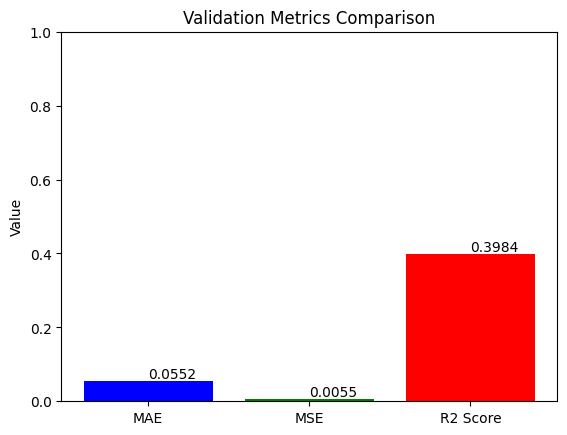

C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Validation Set


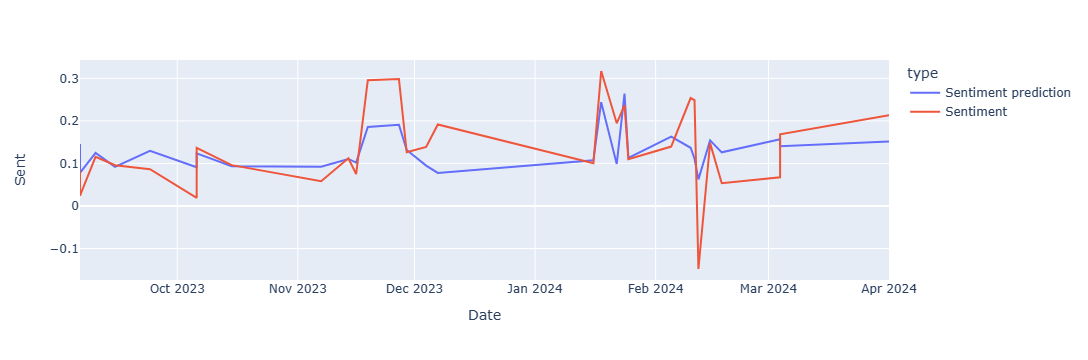

######## Publisher: cnn ###########

3 Articles in Topic 1 for publisher cnn in testing set.
TESTING SCORES FOR PUBLISHER: cnn


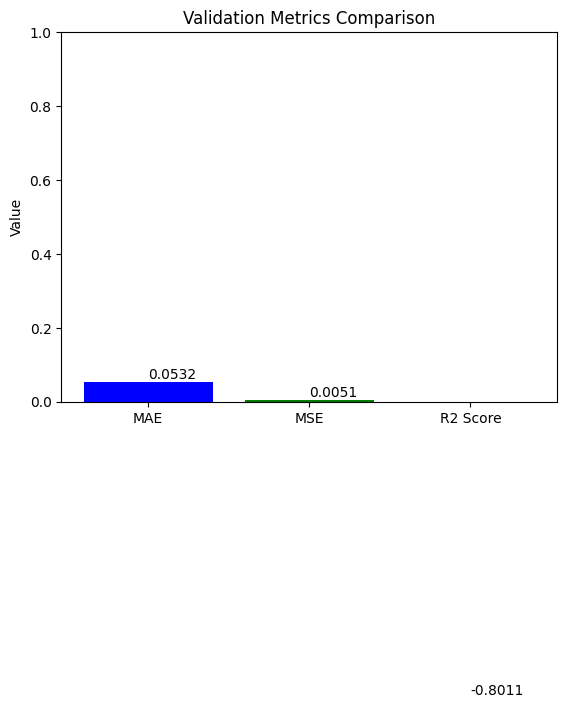

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



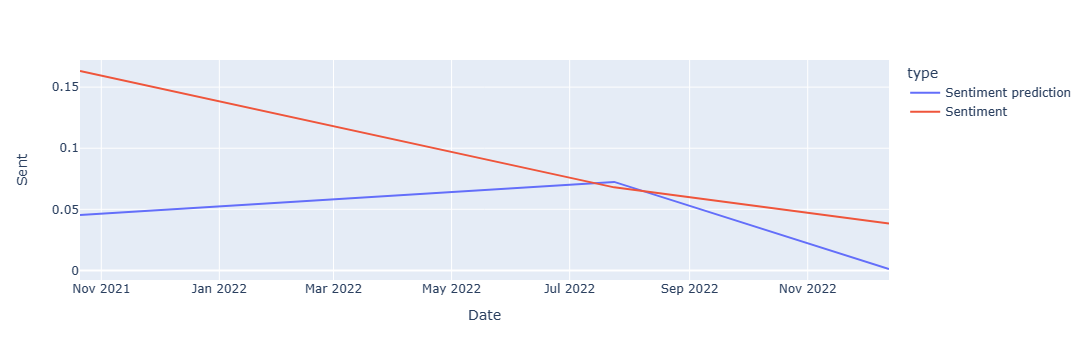

11 Articles in Topic 1 for publisher cnn in validation set.


VALIDATION SCORES FOR PUBLISHER: cnn


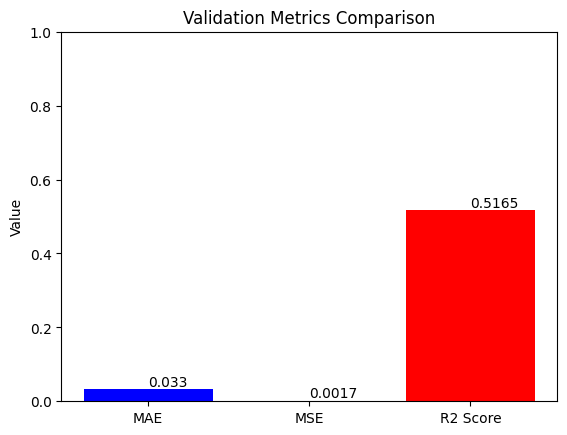

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Validation Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



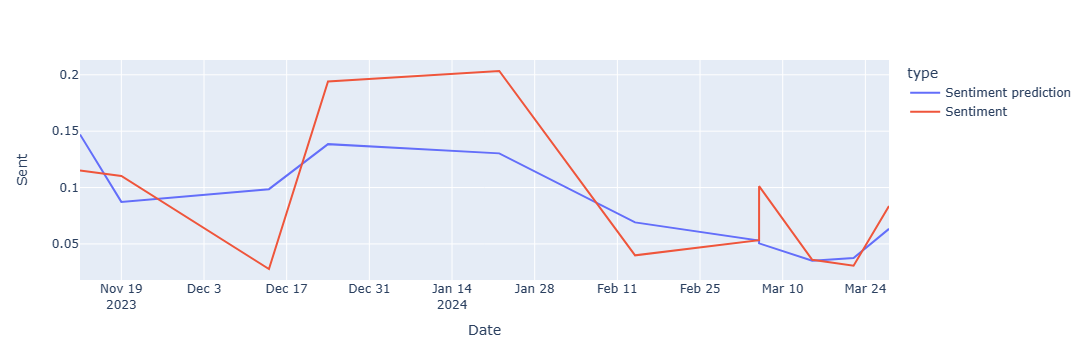

######## Publisher: kbtx ###########

7 Articles in Topic 1 for publisher kbtx in testing set.
TESTING SCORES FOR PUBLISHER: kbtx


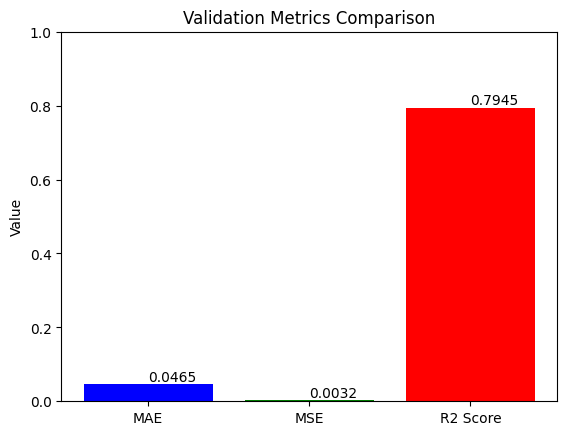

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Testing Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



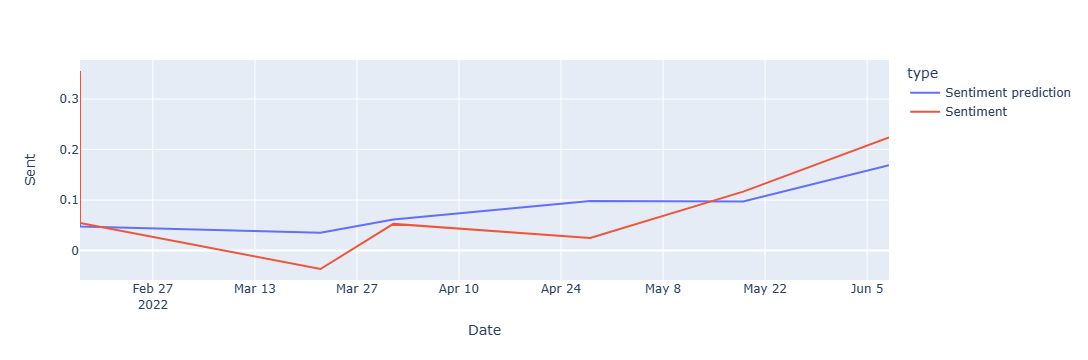

5 Articles in Topic 1 for publisher kbtx in validation set.


VALIDATION SCORES FOR PUBLISHER: kbtx


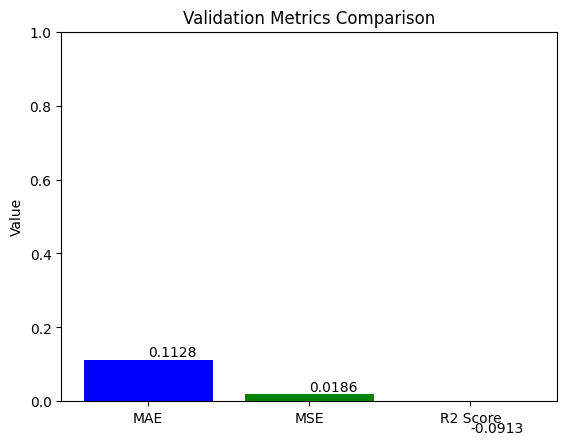

MAE: MEAN ABSOLUTE ERROR
MSE: MEAN SQUARED ERROR
R2 SCORE: COEFFICIENT OF DETERMINATION

Feature Vector with all Features

Prediction of the Validation Set


C:\Users\jimni\LocalCapstone\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



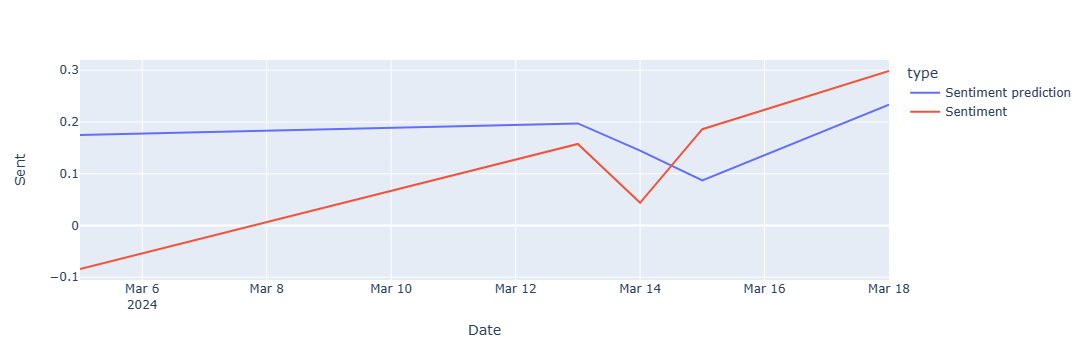

In [42]:
#print(pred_eval)
#print(pred_eval.columns)
for i in publisher_map:
    #if publisher_map.get(i) not in pred_eval["Publisher_Id"]:
    #    print("There are no articles from", i,"in the testing set")
    #    continue
    print("######## Publisher:", i,"###########\n")
    publish_eval = pd.DataFrame(columns=['year', 'month','day', 'neg', 'neu', 'pos', 'compound', 'Subjectivity', 'Topic_Prob', 'Publisher_Id', "Sentiment prediction", "Date", "Sentiment", "Article"])
    index = 0
    for index, row in pred_eval.iterrows():
        #print(row["Publisher_Id"])
        if row['Publisher_Id'] == publisher_map.get(i):
            publish_eval.loc[index] = row
            index += 1



    if not publish_eval.empty:
        print(len(publish_eval), "Articles in Topic", inp, "for publisher", i, "in testing set.")
        print("TESTING SCORES FOR PUBLISHER:", i)
        mae = mean_absolute_error(publish_eval["Sentiment"], publish_eval['Sentiment prediction'])
        #print('Mean Absolute Error:', mae)
        
        mse = mean_squared_error(publish_eval["Sentiment"], publish_eval['Sentiment prediction'])
        #print('Mean Squared Error:', mse)
        rmse = root_mean_squared_error(publish_eval["Sentiment"], publish_eval['Sentiment prediction'])
        #print('Root Mean Squared Error:', rmse)
        
        r2 = r2_score(publish_eval["Sentiment"], publish_eval["Sentiment prediction"])
        #print('R2 Score:', r2)
        # Plotting
        fig, ax = plt.subplots()
        
        # Data for plotting
        metrics = ['MAE', 'MSE', 'R2 Score']
        values = [mae, mse, r2]
        
        # Plot histogram
        bars = ax.bar(metrics, values, color=['blue', 'green', 'red'])
        
        # Add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')
        
        # Add title and labels
        ax.set_title('Validation Metrics Comparison')
        ax.set_ylabel('Value')
        ax.set_ylim(0, 1)
        # Show plot
        plt.show()
        print("MAE: MEAN ABSOLUTE ERROR\nMSE: MEAN SQUARED ERROR\nR2 SCORE: COEFFICIENT OF DETERMINATION")
                
        print("\nFeature Vector with all Features\n\nPrediction of the Testing Set")
        pred_vis = publish_eval.melt(id_vars = ["Date"], value_vars = ["Sentiment prediction", "Sentiment"],var_name = "type", value_name = "Sent")
        
        fig = px.line(pred_vis, x = "Date", y = "Sent", color = "type", )
        fig.show()
    else:
        print("There were no articles from", i, "in the testing set")
    
    publish_valid = pd.DataFrame(columns=['year', 'month','day', 'neg', 'neu', 'pos', 'compound', 'Subjectivity', 'Topic_Prob', 'Publisher_Id', "Sentiment prediction", "Date", "Sentiment", "Article"])
    index = 0

    
    for index, row in pred_valid.iterrows():
        #print(row["Publisher_Id"])
        if row['Publisher_Id'] == publisher_map.get(i):
            publish_valid.loc[index] = row
            index += 1


    if not publish_valid.empty:
        
        print(len(publish_valid), "Articles in Topic", inp, "for publisher", i, "in validation set.")
        print("\n\nVALIDATION SCORES FOR PUBLISHER:", i)
        mae = mean_absolute_error(publish_valid["Sentiment"], publish_valid['Sentiment prediction'])
        #print('Mean Absolute Error:', mae)
        
        mse = mean_squared_error(publish_valid["Sentiment"], publish_valid['Sentiment prediction'])
        #print('Mean Squared Error:', mse)
        rmse = root_mean_squared_error(publish_valid["Sentiment"], publish_valid['Sentiment prediction'])
        #print('Root Mean Squared Error:', rmse)
        
        r2 = r2_score(publish_valid["Sentiment"], publish_valid["Sentiment prediction"])
        #print('R2 Score:', r2,'\n\n')
        # Plotting
        fig, ax = plt.subplots()
        
        # Data for plotting
        metrics = ['MAE', 'MSE', 'R2 Score']
        values = [mae, mse, r2]
        
        # Plot histogram
        bars = ax.bar(metrics, values, color=['blue', 'green', 'red'])
        
        # Add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')
        
        # Add title and labels
        ax.set_title('Validation Metrics Comparison')
        ax.set_ylabel('Value')
        ax.set_ylim(0, 1)
        # Show plot
        plt.show()
        print("MAE: MEAN ABSOLUTE ERROR\nMSE: MEAN SQUARED ERROR\nR2 SCORE: COEFFICIENT OF DETERMINATION")
        
        print("\nFeature Vector with all Features\n\nPrediction of the Validation Set")
        pred_vis = publish_valid.melt(id_vars = ["Date"], value_vars = ["Sentiment prediction", "Sentiment"],var_name = "type", value_name = "Sent")
        
        fig = px.line(pred_vis, x = "Date", y = "Sent", color = "type", )
        fig.show()

    else:
        print("There were no articles from", i, "in the validation set")
    
    #print(pred_valid.shape[0], x_valid.shape[1])